### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл) 

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [26]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [34]:
class Config:
    mnist_path: str
    batch_size: int
    num_workers: int
    num_epochs: int
    noise_size: int
    print_freq: int
    lr: int
    weight_cliping_limit: float
    num_critic: int
    num_classes: int


config = Config()
config.mnist_path = None
config.batch_size = 128
config.num_workers = 1
config.num_epochs = 50
config.noise_size = 100
config.print_freq = 100
config.lr = 0.00005
config.weight_cliping_limit = 0.01
config.num_critic = 5
config.num_classes = 10

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train = torchvision.datasets.FashionMNIST(
    "fashion_mnist",
    train=True,
    transform=transform,
    download=True,
)

dataloader = DataLoader(
    train, batch_size=config.batch_size, shuffle=True, drop_last=True
)

In [4]:
for image, cat in dataloader:
    break

image.size()

torch.Size([128, 1, 32, 32])

WGAN with weight clipping

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=1024,
                kernel_size=4,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),
            # State (1024x4x4)
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),
            # State (512x8x8)
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            # State (256x16x16)
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
        )
        self.output = nn.Tanh()

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=256,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True),
            # State (256x16x16)
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, inplace=True),
            # State (512x8x8)
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.output = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0
            )
        )

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x

In [6]:
generator = Generator(in_channels=config.noise_size, out_channels=1).to(device)
discriminator = Discriminator(in_channels=1).to(device)

In [7]:
optim_G = optim.RMSprop(params=generator.parameters(), lr=config.lr)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=config.lr)

In [8]:
input = Variable(torch.FloatTensor(config.batch_size, 32 * 32))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, 1, 1)).to(
    device
)
fixed_noise = Variable(
    torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)
)
label = Variable(torch.FloatTensor(config.batch_size))
label = label.unsqueeze(1).to(device)
real_label = 1
fake_label = 0

In [9]:
ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(tqdm(dataloader)):
        # Discriminator stage #
        losses_D = []
        for i in range(config.num_critic):
            discriminator.zero_grad()

            input_data = images.to(device)
            noise.data.normal_(0, 1)
            fake_data = generator(noise)

            real_output = discriminator(input_data)
            fake_output = discriminator(fake_data.detach())
            loss_D = -(torch.mean(real_output) - torch.mean(fake_output))

            losses_D.append(loss_D.item())
            loss_D.backward()
            optim_D.step()

            for p in discriminator.parameters():
                p.data.clamp_(-config.weight_cliping_limit, config.weight_cliping_limit)

        ERRD[epoch] += np.mean(losses_D)

        # Generator stage #
        generator.zero_grad()
        fake_output = discriminator(fake_data)
        loss_G = -torch.mean(fake_output)

        ERRG[epoch] += loss_G.item()
        loss_G.backward()
        optim_G.step()

    print(
        "Epoch:{} Iter: {} loss_D: {:.2f} loss_G: {:.2f}".format(
            epoch + 1, iteration + 1, loss_D.item(), loss_G.item()
        )
    )

100%|██████████| 468/468 [00:38<00:00, 12.30it/s]


Epoch:1 Iter: 468 loss_D: -2.97 loss_G: 1.47


100%|██████████| 468/468 [00:37<00:00, 12.34it/s]


Epoch:2 Iter: 468 loss_D: -3.06 loss_G: 1.51


100%|██████████| 468/468 [00:37<00:00, 12.37it/s]


Epoch:3 Iter: 468 loss_D: -3.08 loss_G: 1.52


100%|██████████| 468/468 [00:37<00:00, 12.35it/s]


Epoch:4 Iter: 468 loss_D: -3.06 loss_G: 1.51


100%|██████████| 468/468 [00:37<00:00, 12.41it/s]


Epoch:5 Iter: 468 loss_D: -3.09 loss_G: 1.52


100%|██████████| 468/468 [00:37<00:00, 12.42it/s]


Epoch:6 Iter: 468 loss_D: -3.03 loss_G: 1.49


100%|██████████| 468/468 [00:37<00:00, 12.35it/s]


Epoch:7 Iter: 468 loss_D: -2.98 loss_G: 1.46


100%|██████████| 468/468 [00:37<00:00, 12.38it/s]


Epoch:8 Iter: 468 loss_D: -3.08 loss_G: 1.52


100%|██████████| 468/468 [00:37<00:00, 12.42it/s]


Epoch:9 Iter: 468 loss_D: -3.05 loss_G: 1.50


100%|██████████| 468/468 [00:37<00:00, 12.44it/s]


Epoch:10 Iter: 468 loss_D: -3.09 loss_G: 1.52


100%|██████████| 468/468 [00:37<00:00, 12.46it/s]


Epoch:11 Iter: 468 loss_D: -3.08 loss_G: 1.52


100%|██████████| 468/468 [00:37<00:00, 12.42it/s]


Epoch:12 Iter: 468 loss_D: -3.07 loss_G: 1.51


100%|██████████| 468/468 [00:37<00:00, 12.41it/s]


Epoch:13 Iter: 468 loss_D: -3.07 loss_G: 1.51


100%|██████████| 468/468 [00:37<00:00, 12.45it/s]


Epoch:14 Iter: 468 loss_D: -3.06 loss_G: 1.50


100%|██████████| 468/468 [00:37<00:00, 12.53it/s]


Epoch:15 Iter: 468 loss_D: -3.08 loss_G: 1.51


100%|██████████| 468/468 [00:36<00:00, 12.67it/s]


Epoch:16 Iter: 468 loss_D: -3.02 loss_G: 1.48


100%|██████████| 468/468 [00:37<00:00, 12.58it/s]


Epoch:17 Iter: 468 loss_D: -2.00 loss_G: 0.26


100%|██████████| 468/468 [00:36<00:00, 12.67it/s]


Epoch:18 Iter: 468 loss_D: -1.25 loss_G: -0.14


100%|██████████| 468/468 [00:36<00:00, 12.71it/s]


Epoch:19 Iter: 468 loss_D: -2.93 loss_G: 1.45


100%|██████████| 468/468 [00:36<00:00, 12.70it/s]


Epoch:20 Iter: 468 loss_D: -3.01 loss_G: 1.48


100%|██████████| 468/468 [00:37<00:00, 12.49it/s]


Epoch:21 Iter: 468 loss_D: -2.74 loss_G: 1.35


100%|██████████| 468/468 [00:47<00:00,  9.90it/s]


Epoch:22 Iter: 468 loss_D: -3.05 loss_G: 1.50


100%|██████████| 468/468 [00:41<00:00, 11.16it/s]


Epoch:23 Iter: 468 loss_D: -3.09 loss_G: 1.53


100%|██████████| 468/468 [00:37<00:00, 12.42it/s]


Epoch:24 Iter: 468 loss_D: -2.12 loss_G: 1.09


100%|██████████| 468/468 [00:37<00:00, 12.47it/s]


Epoch:25 Iter: 468 loss_D: -2.80 loss_G: 1.37


100%|██████████| 468/468 [00:38<00:00, 12.31it/s]


Epoch:26 Iter: 468 loss_D: -3.01 loss_G: 1.49


100%|██████████| 468/468 [00:37<00:00, 12.39it/s]


Epoch:27 Iter: 468 loss_D: -1.25 loss_G: -0.63


100%|██████████| 468/468 [00:37<00:00, 12.47it/s]


Epoch:28 Iter: 468 loss_D: -2.92 loss_G: 1.45


100%|██████████| 468/468 [00:37<00:00, 12.48it/s]


Epoch:29 Iter: 468 loss_D: -2.99 loss_G: 1.48


100%|██████████| 468/468 [00:37<00:00, 12.48it/s]


Epoch:30 Iter: 468 loss_D: -2.87 loss_G: 1.41


100%|██████████| 468/468 [00:37<00:00, 12.52it/s]


Epoch:31 Iter: 468 loss_D: -2.25 loss_G: 1.19


100%|██████████| 468/468 [00:36<00:00, 12.65it/s]


Epoch:32 Iter: 468 loss_D: -0.22 loss_G: 1.38


100%|██████████| 468/468 [00:37<00:00, 12.63it/s]


Epoch:33 Iter: 468 loss_D: -2.83 loss_G: 1.40


100%|██████████| 468/468 [00:36<00:00, 12.65it/s]


Epoch:34 Iter: 468 loss_D: -1.34 loss_G: 1.33


100%|██████████| 468/468 [00:36<00:00, 12.67it/s]


Epoch:35 Iter: 468 loss_D: -1.82 loss_G: 1.34


100%|██████████| 468/468 [00:37<00:00, 12.56it/s]


Epoch:36 Iter: 468 loss_D: -1.92 loss_G: 0.64


100%|██████████| 468/468 [00:36<00:00, 12.68it/s]


Epoch:37 Iter: 468 loss_D: -1.85 loss_G: 0.55


100%|██████████| 468/468 [00:36<00:00, 12.70it/s]


Epoch:38 Iter: 468 loss_D: -1.85 loss_G: 1.32


100%|██████████| 468/468 [00:36<00:00, 12.70it/s]


Epoch:39 Iter: 468 loss_D: -2.87 loss_G: 1.41


100%|██████████| 468/468 [00:36<00:00, 12.66it/s]


Epoch:40 Iter: 468 loss_D: -2.80 loss_G: 1.38


100%|██████████| 468/468 [00:37<00:00, 12.60it/s]


Epoch:41 Iter: 468 loss_D: -1.56 loss_G: 0.22


100%|██████████| 468/468 [00:37<00:00, 12.63it/s]


Epoch:42 Iter: 468 loss_D: -2.75 loss_G: 1.36


100%|██████████| 468/468 [00:37<00:00, 12.60it/s]


Epoch:43 Iter: 468 loss_D: -2.83 loss_G: 1.41


100%|██████████| 468/468 [00:36<00:00, 12.65it/s]


Epoch:44 Iter: 468 loss_D: -2.52 loss_G: 0.90


100%|██████████| 468/468 [00:37<00:00, 12.58it/s]


Epoch:45 Iter: 468 loss_D: -2.82 loss_G: 1.39


100%|██████████| 468/468 [00:37<00:00, 12.56it/s]


Epoch:46 Iter: 468 loss_D: -1.51 loss_G: 0.18


100%|██████████| 468/468 [00:36<00:00, 12.69it/s]


Epoch:47 Iter: 468 loss_D: -2.37 loss_G: 1.28


100%|██████████| 468/468 [00:36<00:00, 12.68it/s]


Epoch:48 Iter: 468 loss_D: -1.45 loss_G: 1.18


100%|██████████| 468/468 [00:36<00:00, 12.69it/s]


Epoch:49 Iter: 468 loss_D: -2.09 loss_G: 1.33


100%|██████████| 468/468 [00:37<00:00, 12.64it/s]

Epoch:50 Iter: 468 loss_D: -2.65 loss_G: 1.30


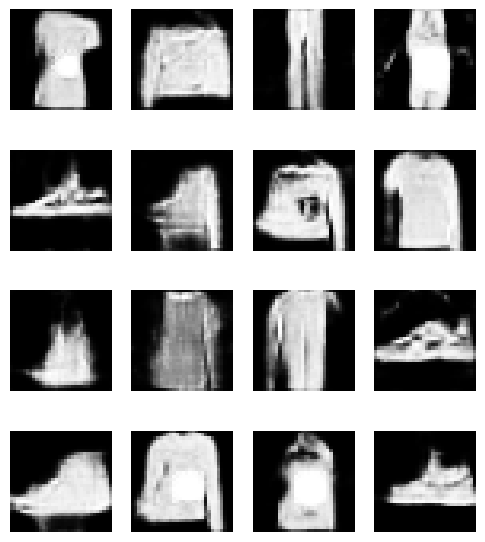

In [10]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
    plt.axis("off")

WGAN with gradient penalty

In [15]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=1024,
                kernel_size=4,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),
            # State (1024x4x4)
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),
            # State (512x8x8)
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            # State (256x16x16)
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
        )
        self.output = nn.Tanh()

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=256,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # State (256x16x16)
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=512),
            nn.InstanceNorm2d(512, affine=True),
            # State (512x8x8)
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1
            ),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.output = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0
            )
        )

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x


class WGAN_GP(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size, noise_size):
        super(WGAN_GP, self).__init__()
        self.generator = Generator(in_channels, out_channels).to(device)
        self.discriminator = Discriminator(out_channels).to(device)

        self.batch_size = batch_size
        self.noise_size = noise_size
        self.lambda_rate = 10
        self.lr = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.9

        self.optim_g = optim.Adam(
            self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )
        self.optim_d = optim.Adam(
            self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )

        self.input = Variable(torch.FloatTensor(self.batch_size, 32 * 32))
        self.noise = Variable(
            torch.FloatTensor(self.batch_size, self.noise_size, 1, 1)
        ).to(device)

    def compute_gradient_penalty(self, real_samples, fake_samples):
        alpha = torch.FloatTensor(self.batch_size, 1, 1, 1).uniform_(0, 1).to(device)
        alpha = alpha.expand(
            self.batch_size,
            real_samples.size(1),
            real_samples.size(2),
            real_samples.size(3),
        )
        interpolated = alpha * real_samples + ((1 - alpha) * fake_samples)
        interpolated = Variable(interpolated, requires_grad=True).to(device)

        d_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=d_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(d_interpolated.size()).to(device),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = (
            (gradients.norm(2, dim=1) - 1) ** 2
        ).mean() * self.lambda_rate
        return gradient_penalty

    def fit(self, dataloader, num_epochs, num_critic):
        ERRD = np.zeros(num_epochs)
        ERRG = np.zeros(num_epochs)
        for epoch in range(num_epochs):
            for iteration, (images, _) in enumerate(tqdm(dataloader)):
                # Discriminator stage #
                losses_D = []
                for i in range(num_critic):
                    self.discriminator.zero_grad()

                    input_data = images.to(device)
                    self.noise.data.normal_(0, 1)
                    fake_data = self.generator(self.noise)

                    real_output = self.discriminator(input_data)
                    fake_output = self.discriminator(fake_data.detach())
                    gradient_penalty = self.compute_gradient_penalty(
                        input_data.detach(), fake_data.detach()
                    )
                    loss_D = (
                        -(torch.mean(real_output) - torch.mean(fake_output))
                        + gradient_penalty
                    )

                    losses_D.append(-loss_D.item())
                    loss_D.backward()
                    self.optim_d.step()

                ERRD[epoch] += np.mean(losses_D)

                # Generator stage #
                self.generator.zero_grad()
                fake_output = self.discriminator(fake_data)
                loss_G = -torch.mean(fake_output)

                ERRG[epoch] += loss_G.item()
                loss_G.backward()
                self.optim_g.step()

            print(
                "Epoch:{} loss_D: {:.2f} loss_G: {:.2f}".format(
                    epoch + 1, ERRD[epoch], ERRG[epoch]
                )
            )
        return ERRD, ERRG

In [16]:
wgan_gp = WGAN_GP(
    in_channels=config.noise_size,
    out_channels=1,
    batch_size=config.batch_size,
    noise_size=config.noise_size,
)

wgan_gp.fit(
    dataloader=dataloader, num_epochs=config.num_epochs, num_critic=config.num_critic
)

100%|██████████| 468/468 [01:46<00:00,  4.39it/s]


Epoch:1 loss_D: 4078.66 loss_G: 43.86


100%|██████████| 468/468 [01:49<00:00,  4.29it/s]


Epoch:2 loss_D: 1959.57 loss_G: -130.09


100%|██████████| 468/468 [01:49<00:00,  4.27it/s]


Epoch:3 loss_D: 1669.05 loss_G: 1359.26


100%|██████████| 468/468 [01:48<00:00,  4.30it/s]


Epoch:4 loss_D: 1560.56 loss_G: 2889.84


100%|██████████| 468/468 [01:48<00:00,  4.30it/s]


Epoch:5 loss_D: 1707.65 loss_G: 5711.59


100%|██████████| 468/468 [01:48<00:00,  4.30it/s]


Epoch:6 loss_D: 1583.77 loss_G: 8093.98


100%|██████████| 468/468 [01:48<00:00,  4.31it/s]


Epoch:7 loss_D: 1505.53 loss_G: 9600.43


100%|██████████| 468/468 [01:48<00:00,  4.29it/s]


Epoch:8 loss_D: 1432.77 loss_G: 11035.32


100%|██████████| 468/468 [01:48<00:00,  4.30it/s]


Epoch:9 loss_D: 1361.98 loss_G: 12166.79


100%|██████████| 468/468 [01:48<00:00,  4.30it/s]


Epoch:10 loss_D: 1321.40 loss_G: 13437.88


100%|██████████| 468/468 [01:48<00:00,  4.29it/s]


Epoch:11 loss_D: 1326.51 loss_G: 14713.00


100%|██████████| 468/468 [01:49<00:00,  4.29it/s]


Epoch:12 loss_D: 1274.40 loss_G: 15860.22


100%|██████████| 468/468 [01:48<00:00,  4.31it/s]


Epoch:13 loss_D: 1256.76 loss_G: 16908.84


100%|██████████| 468/468 [01:47<00:00,  4.35it/s]


Epoch:14 loss_D: 1271.07 loss_G: 17906.02


100%|██████████| 468/468 [01:52<00:00,  4.16it/s]


Epoch:15 loss_D: 1228.49 loss_G: 18732.80


100%|██████████| 468/468 [01:52<00:00,  4.16it/s]


Epoch:16 loss_D: 1241.11 loss_G: 19640.75


100%|██████████| 468/468 [01:50<00:00,  4.25it/s]


Epoch:17 loss_D: 1213.74 loss_G: 20608.77


100%|██████████| 468/468 [01:51<00:00,  4.20it/s]


Epoch:18 loss_D: 1193.65 loss_G: 21308.40


100%|██████████| 468/468 [01:49<00:00,  4.26it/s]


Epoch:19 loss_D: 1227.72 loss_G: 22135.79


100%|██████████| 468/468 [01:49<00:00,  4.27it/s]


Epoch:20 loss_D: 1166.87 loss_G: 23218.75


100%|██████████| 468/468 [01:50<00:00,  4.23it/s]


Epoch:21 loss_D: 1193.83 loss_G: 24038.86


100%|██████████| 468/468 [01:48<00:00,  4.30it/s]


Epoch:22 loss_D: 1142.21 loss_G: 24609.13


100%|██████████| 468/468 [01:48<00:00,  4.33it/s]


Epoch:23 loss_D: 1079.43 loss_G: 25357.20


100%|██████████| 468/468 [01:50<00:00,  4.25it/s]


Epoch:24 loss_D: 1269.94 loss_G: 25434.03


100%|██████████| 468/468 [01:49<00:00,  4.29it/s]


Epoch:25 loss_D: 1201.42 loss_G: 26161.03


100%|██████████| 468/468 [01:49<00:00,  4.28it/s]


Epoch:26 loss_D: 1149.47 loss_G: 26682.51


100%|██████████| 468/468 [01:44<00:00,  4.49it/s]


Epoch:27 loss_D: 1060.60 loss_G: 26885.07


100%|██████████| 468/468 [01:39<00:00,  4.70it/s]


Epoch:28 loss_D: 1189.73 loss_G: 27242.87


100%|██████████| 468/468 [01:39<00:00,  4.69it/s]


Epoch:29 loss_D: 1160.10 loss_G: 27583.64


100%|██████████| 468/468 [01:39<00:00,  4.68it/s]


Epoch:30 loss_D: 948.14 loss_G: 28087.83


100%|██████████| 468/468 [01:37<00:00,  4.80it/s]


Epoch:31 loss_D: 1081.14 loss_G: 28213.47


100%|██████████| 468/468 [01:37<00:00,  4.80it/s]


Epoch:32 loss_D: 1011.99 loss_G: 28724.20


100%|██████████| 468/468 [01:37<00:00,  4.79it/s]


Epoch:33 loss_D: 1166.44 loss_G: 29171.23


100%|██████████| 468/468 [01:37<00:00,  4.81it/s]


Epoch:34 loss_D: 1205.82 loss_G: 29402.11


100%|██████████| 468/468 [01:37<00:00,  4.81it/s]


Epoch:35 loss_D: 1118.20 loss_G: 29638.47


100%|██████████| 468/468 [01:37<00:00,  4.79it/s]


Epoch:36 loss_D: 1128.50 loss_G: 30004.51


100%|██████████| 468/468 [01:39<00:00,  4.70it/s]


Epoch:37 loss_D: 1127.62 loss_G: 30403.83


100%|██████████| 468/468 [01:39<00:00,  4.72it/s]


Epoch:38 loss_D: 1202.83 loss_G: 30714.40


100%|██████████| 468/468 [01:39<00:00,  4.70it/s]


Epoch:39 loss_D: 1149.87 loss_G: 31559.20


100%|██████████| 468/468 [01:37<00:00,  4.80it/s]


Epoch:40 loss_D: 1101.52 loss_G: 32160.20


100%|██████████| 468/468 [01:37<00:00,  4.82it/s]


Epoch:41 loss_D: 770.19 loss_G: 32616.36


100%|██████████| 468/468 [01:38<00:00,  4.76it/s]


Epoch:42 loss_D: 1084.09 loss_G: 33408.12


100%|██████████| 468/468 [01:45<00:00,  4.46it/s]


Epoch:43 loss_D: 1040.87 loss_G: 33261.05


100%|██████████| 468/468 [01:41<00:00,  4.61it/s]


Epoch:44 loss_D: 1053.34 loss_G: 33717.37


100%|██████████| 468/468 [01:48<00:00,  4.33it/s]


Epoch:45 loss_D: 985.71 loss_G: 34631.12


100%|██████████| 468/468 [01:46<00:00,  4.38it/s]


Epoch:46 loss_D: 1081.82 loss_G: 36147.23


100%|██████████| 468/468 [01:48<00:00,  4.30it/s]


Epoch:47 loss_D: 992.29 loss_G: 36249.02


100%|██████████| 468/468 [01:49<00:00,  4.29it/s]


Epoch:48 loss_D: 1147.05 loss_G: 37358.77


100%|██████████| 468/468 [01:49<00:00,  4.28it/s]


Epoch:49 loss_D: 1075.33 loss_G: 38254.18


100%|██████████| 468/468 [01:39<00:00,  4.69it/s]

Epoch:50 loss_D: 979.96 loss_G: 38425.13


(array([4078.66098912, 1959.57303774, 1669.04522164, 1560.55551517,
        1707.65474098, 1583.76656398, 1505.53136376, 1432.77012074,
        1361.98165735, 1321.40272551, 1326.51408058, 1274.40062873,
        1256.76126024, 1271.06602659, 1228.49122651, 1241.1078825 ,
        1213.73793011, 1193.64581909, 1227.72248967, 1166.87433194,
        1193.83213655, 1142.20851786, 1079.43016284, 1269.94165708,
        1201.41680806, 1149.47246373, 1060.60300784, 1189.73068184,
        1160.09907258,  948.14050227, 1081.14187704, 1011.98648168,
        1166.443761  , 1205.81777397, 1118.20287265, 1128.4986247 ,
        1127.61678987, 1202.82563561, 1149.86610497, 1101.516892  ,
         770.19156914, 1084.08828634, 1040.87324544, 1053.3416188 ,
         985.71094132, 1081.82231606,  992.29146073, 1147.04634127,
        1075.32580802,  979.96183403]),
 array([   43.85585873,  -130.08927754,  1359.25714314,  2889.84241652,
         5711.59324169,  8093.97662926,  9600.4338665 , 11035.32219124,


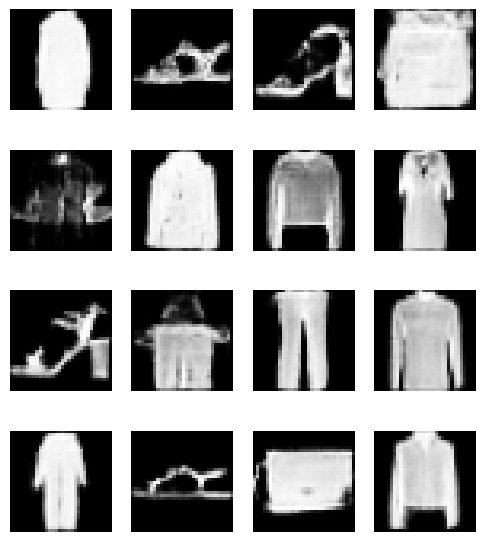

In [18]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, 1, 1)).to(
    device
)
noise.data.normal_(0, 1)
fake = wgan_gp.generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
    plt.axis("off")

Conditional WGAN

In [46]:
def ohe_vector_from_labels(labels, n_classes):
    return F.one_hot(labels, num_classes=n_classes)


def concat_vectors(x, y):
    combined = torch.cat((x.float(), y.float()), 1)
    return combined


def plot_images_from_tensor(
    image_tensor, num_images=25, size=(1, 32, 32), nrow=5, show=True
):
    """
    Plots a grid of images from a given tensor.

    The function first scales the image tensor to the range [0, 1]. It then detaches the tensor from the computation
    graph and moves it to the CPU if it's not already there. After that, it creates a grid of images and plots the grid.

    Args:
        image_tensor (torch.Tensor): A 4D tensor containing the images.
            The tensor is expected to be in the shape (batch_size, channels, height, width).
        num_images (int, optional): The number of images to include in the grid. Default is 25.
        size (tuple, optional): The size of a single image in the form of (channels, height, width). Default is (1, 28, 28).
        nrow (int, optional): Number of images displayed in each row of the grid. The final grid size is (num_images // nrow, nrow). Default is 5.
        show (bool, optional): Determines if the plot should be shown. Default is True.

    Returns:
        None. The function outputs a plot of a grid of images.
    """

    # Normalize the image tensor to [0, 1]
    image_tensor = (image_tensor + 1) / 2

    # Detach the tensor from its computation graph and move it to the CPU
    image_unflat = image_tensor.detach().cpu()

    # Create a grid of images using the make_grid function from torchvision.utils
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)

    # Plot the grid of images
    # The permute() function is used to rearrange the dimensions of the grid for plotting
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

    # Show the plot if the 'show' parameter is True
    if show:
        plt.show()


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=1024,
                kernel_size=4,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),
            # State (1024x4x4)
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),
            # State (512x8x8)
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),
            # State (256x16x16)
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
        )
        self.output = nn.Tanh()

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=256,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # State (256x16x16)
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(num_features=512),
            nn.InstanceNorm2d(512, affine=True),
            # State (512x8x8)
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1
            ),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.output = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0
            )
        )

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x


class CWGAN(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes, batch_size, noise_size):
        super(CWGAN, self).__init__()
        d_in_channels = out_channels + num_classes
        self.generator = Generator(in_channels, out_channels).to(device)
        self.discriminator = Discriminator(d_in_channels).to(device)

        self.num_classes = num_classes
        self.batch_size = batch_size
        self.noise_size = noise_size
        self.lambda_rate = 10
        self.lr = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.9

        self.optim_g = optim.Adam(
            self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )
        self.optim_d = optim.Adam(
            self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )
        self.noise = Variable(torch.FloatTensor(self.batch_size, self.noise_size, 1, 1))

    def compute_gradient_penalty(self, real_samples, fake_samples):
        alpha = torch.FloatTensor(self.batch_size, 1, 1, 1).uniform_(0, 1).to(device)
        alpha = alpha.expand(
            self.batch_size,
            real_samples.size(1),
            real_samples.size(2),
            real_samples.size(3),
        )
        interpolated = alpha * real_samples + ((1 - alpha) * fake_samples)
        interpolated = Variable(interpolated, requires_grad=True).to(device)

        d_interpolated = self.discriminator(interpolated)
        gradients = torch.autograd.grad(
            outputs=d_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones(d_interpolated.size()).to(device),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = (
            (gradients.norm(2, dim=1) - 1) ** 2
        ).mean() * self.lambda_rate
        return gradient_penalty

    def fit(self, dataloader, num_epochs, num_critic):
        ERRD = np.zeros(num_epochs)
        ERRG = np.zeros(num_epochs)
        for epoch in range(num_epochs):
            for iteration, (images, labels) in enumerate(tqdm(dataloader)):
                # Discriminator stage #
                losses_D = []
                for i in range(num_critic):
                    self.discriminator.zero_grad()

                    input_data = images.to(device)

                    one_hot_labels = ohe_vector_from_labels(labels, self.num_classes)
                    image_one_hot_labels = one_hot_labels[:, :, None, None]
                    # State (bs x 10 x 32 x 32)
                    image_one_hot_labels = image_one_hot_labels.repeat(1, 1, 32, 32).to(
                        device
                    )
                    self.noise.data.normal_(0, 1)
                    # State (bs x 110 x 1 x 1)
                    noise_and_labels = concat_vectors(
                        self.noise, one_hot_labels[:, :, None, None]
                    ).to(device)
                    fake_data = self.generator(noise_and_labels)

                    # Concat real images and one hot labels
                    real_data_and_labels = concat_vectors(
                        input_data, image_one_hot_labels
                    ).to(device)
                    # Concat fake images and one hot labels
                    fake_data_and_labels = concat_vectors(
                        fake_data, image_one_hot_labels
                    ).to(device)

                    real_output = self.discriminator(real_data_and_labels)
                    fake_output = self.discriminator(fake_data_and_labels.detach())
                    gradient_penalty = self.compute_gradient_penalty(
                        real_data_and_labels.detach(), fake_data_and_labels.detach()
                    )
                    loss_D = (
                        -(torch.mean(real_output) - torch.mean(fake_output))
                        + gradient_penalty
                    )

                    losses_D.append(-loss_D.item())
                    loss_D.backward()
                    self.optim_d.step()

                ERRD[epoch] += np.mean(losses_D)

                # Generator stage #
                self.generator.zero_grad()

                # Concat fake images and one hot labels
                fake_data_and_labels = concat_vectors(
                    fake_data, image_one_hot_labels
                ).to(device)
                fake_output = self.discriminator(fake_data_and_labels)
                loss_G = -torch.mean(fake_output)

                ERRG[epoch] += loss_G.item()
                loss_G.backward()
                self.optim_g.step()

            print(
                "Epoch:{} loss_D: {:.2f} loss_G: {:.2f}".format(
                    epoch + 1, ERRD[epoch], ERRG[epoch]
                )
            )

            # Plot both the real images and fake generated images
            plot_images_from_tensor(fake_data)
            plot_images_from_tensor(input_data)
        return ERRD, ERRG

100%|██████████| 468/468 [01:46<00:00,  4.38it/s]

Epoch:1 loss_D: 3807.39 loss_G: -5164.00


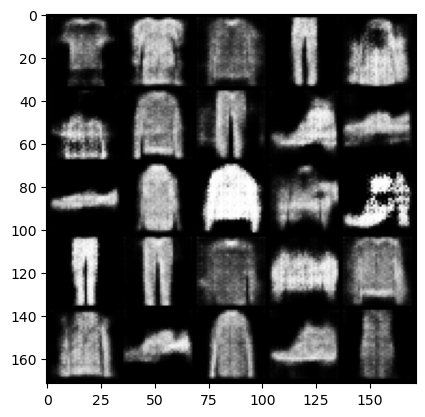

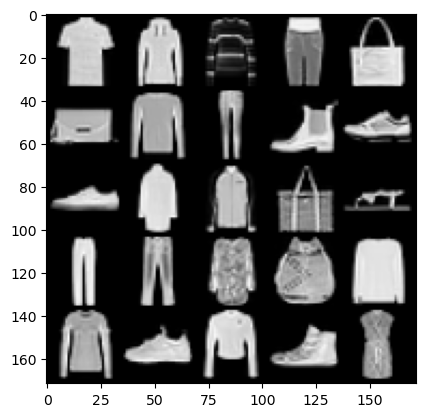

100%|██████████| 468/468 [01:46<00:00,  4.38it/s]

Epoch:2 loss_D: 1837.78 loss_G: -3428.94


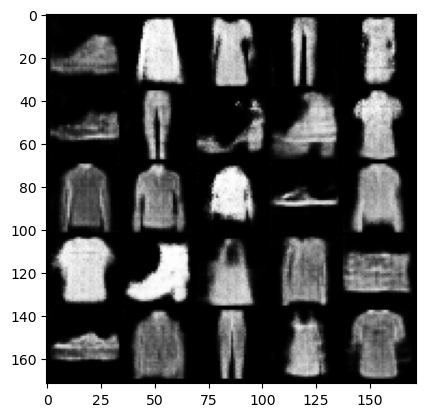

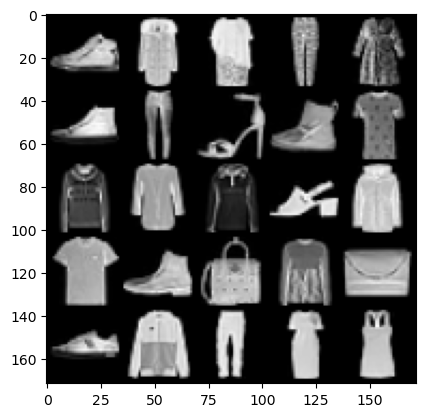

100%|██████████| 468/468 [01:47<00:00,  4.35it/s]

Epoch:3 loss_D: 1464.07 loss_G: 1.49


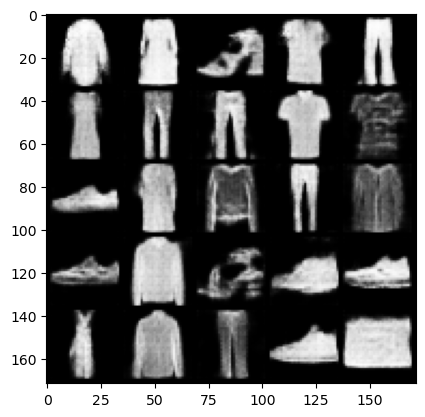

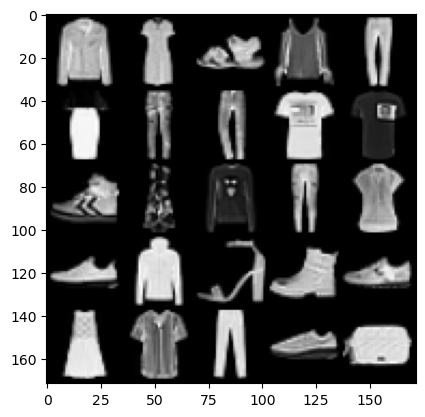

100%|██████████| 468/468 [01:47<00:00,  4.34it/s]

Epoch:4 loss_D: 1285.79 loss_G: 1883.11


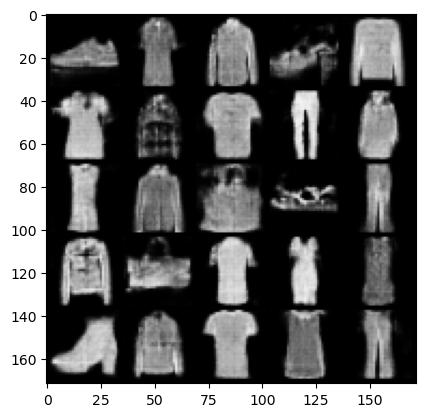

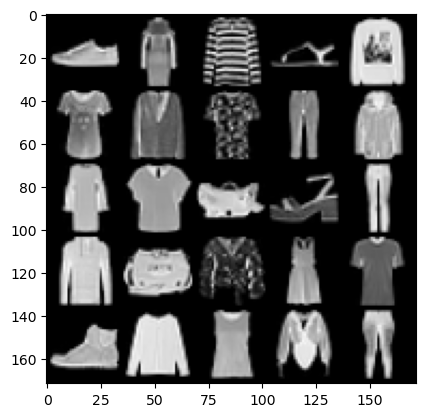

100%|██████████| 468/468 [01:48<00:00,  4.30it/s]

Epoch:5 loss_D: 1169.22 loss_G: 3105.76


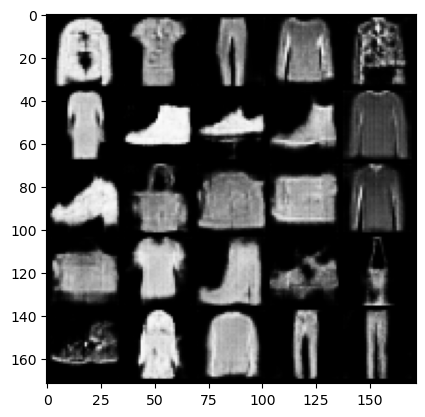

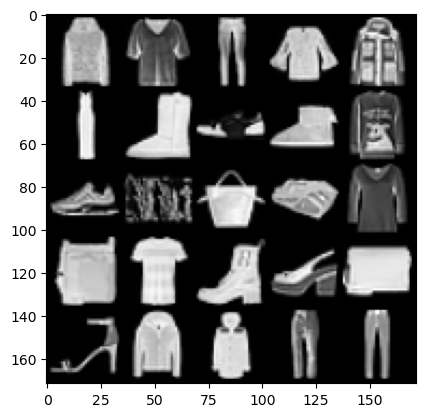

100%|██████████| 468/468 [01:48<00:00,  4.32it/s]

Epoch:6 loss_D: 1114.51 loss_G: 4331.17


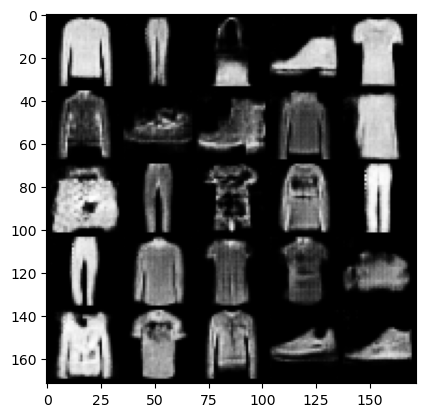

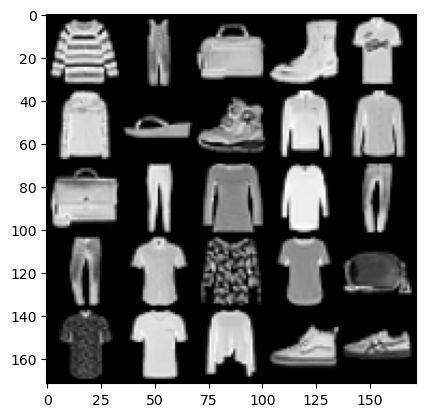

100%|██████████| 468/468 [01:47<00:00,  4.36it/s]

Epoch:7 loss_D: 1098.52 loss_G: 6178.25


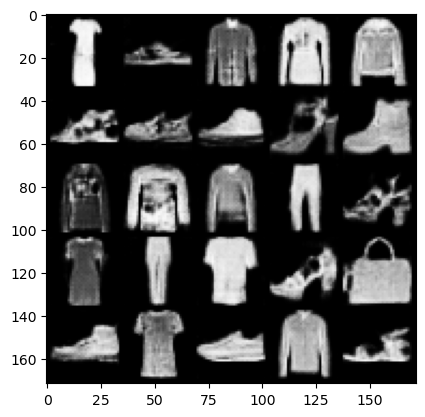

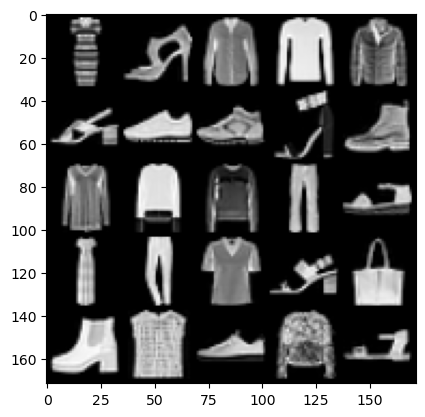

100%|██████████| 468/468 [01:47<00:00,  4.36it/s]

Epoch:8 loss_D: 1074.83 loss_G: 8343.31


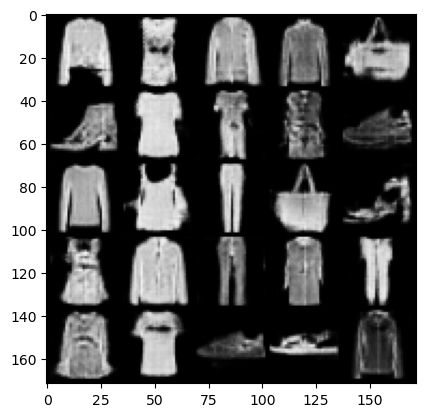

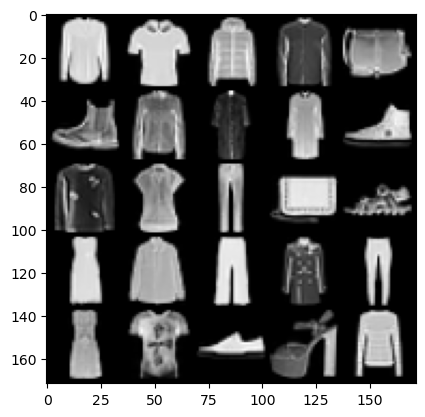

100%|██████████| 468/468 [01:47<00:00,  4.34it/s]

Epoch:9 loss_D: 1051.36 loss_G: 9502.15


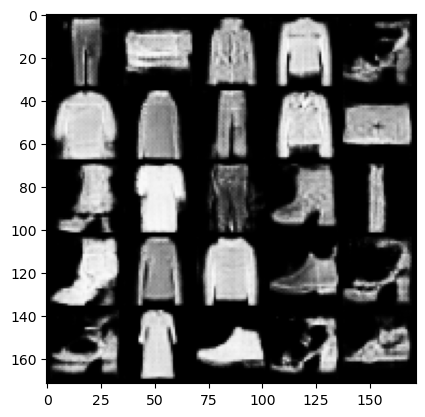

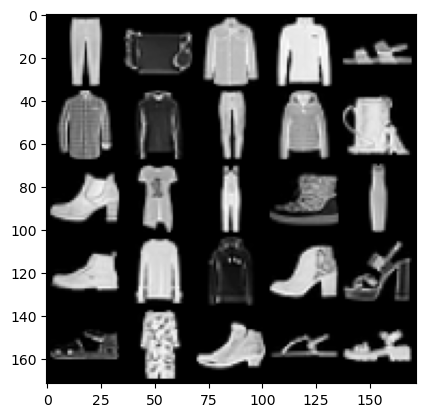

100%|██████████| 468/468 [01:47<00:00,  4.35it/s]

Epoch:10 loss_D: 1006.09 loss_G: 9999.83


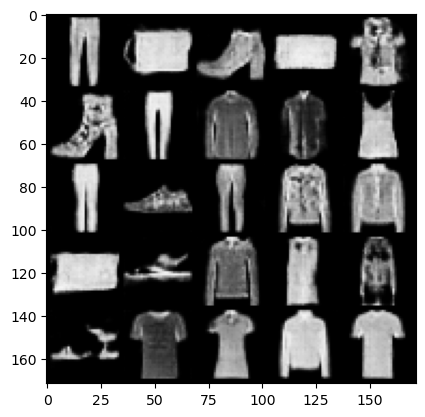

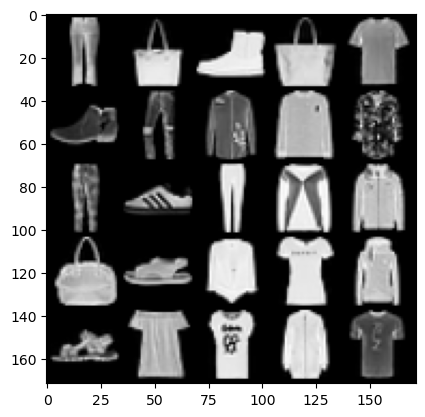

100%|██████████| 468/468 [01:48<00:00,  4.30it/s]

Epoch:11 loss_D: 963.53 loss_G: 10350.09


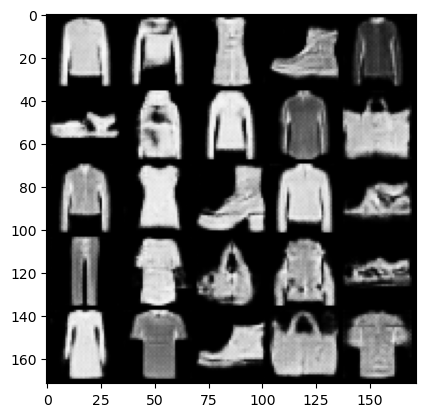

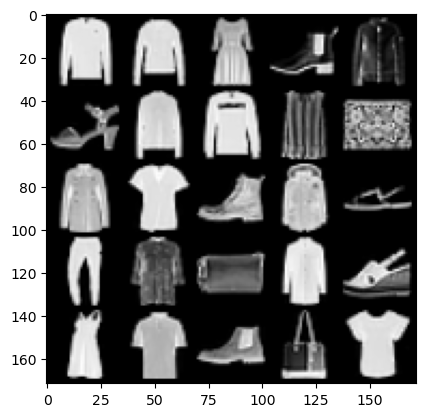

100%|██████████| 468/468 [01:48<00:00,  4.33it/s]

Epoch:12 loss_D: 955.81 loss_G: 10589.42


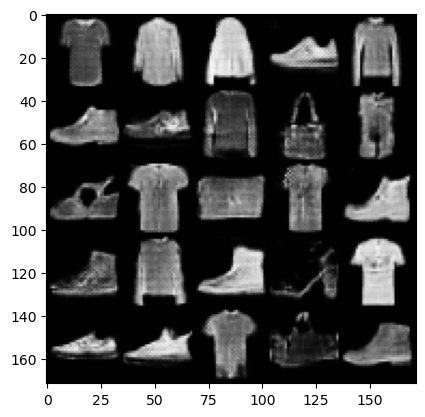

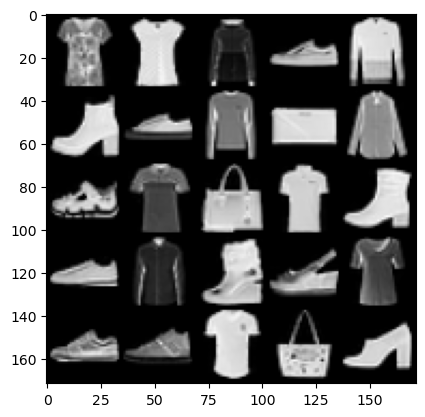

100%|██████████| 468/468 [01:49<00:00,  4.28it/s]

Epoch:13 loss_D: 921.37 loss_G: 10828.47


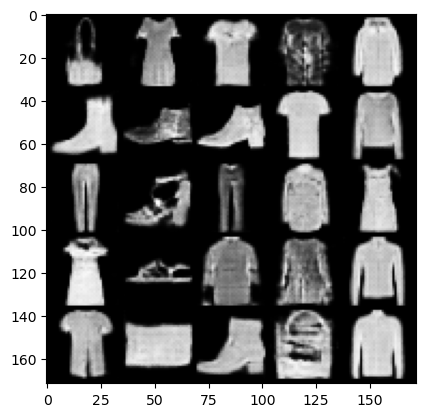

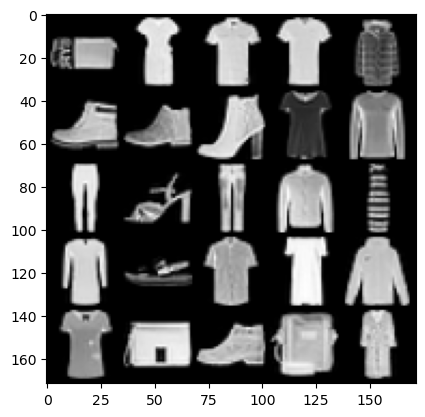

100%|██████████| 468/468 [02:00<00:00,  3.89it/s]

Epoch:14 loss_D: 845.56 loss_G: 10878.25


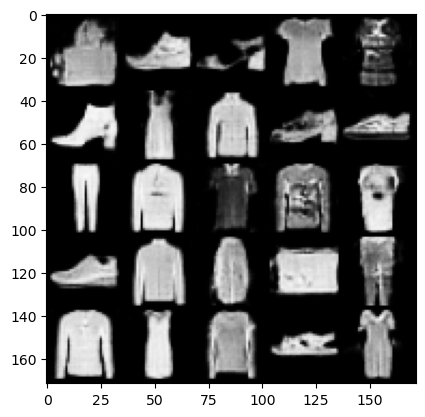

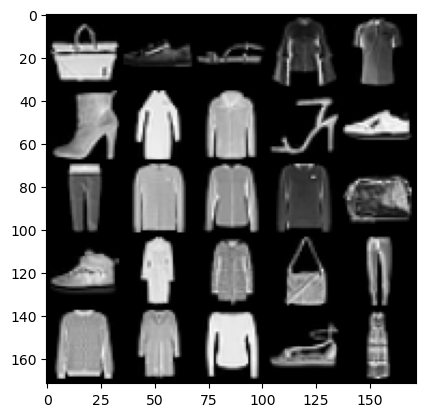

100%|██████████| 468/468 [02:00<00:00,  3.88it/s]

Epoch:15 loss_D: 848.43 loss_G: 10958.35


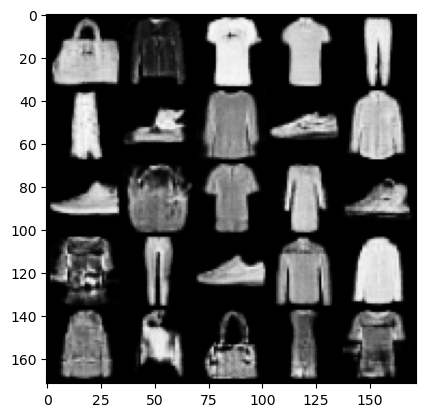

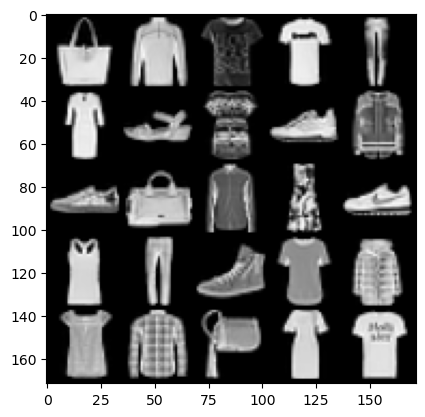

100%|██████████| 468/468 [02:00<00:00,  3.89it/s]

Epoch:16 loss_D: 834.96 loss_G: 11218.34


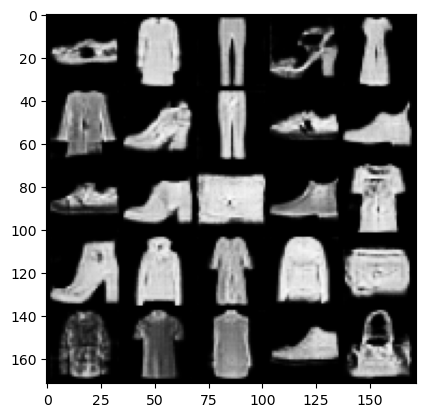

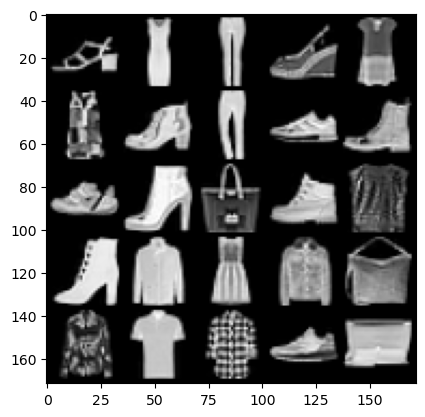

100%|██████████| 468/468 [02:00<00:00,  3.87it/s]

Epoch:17 loss_D: 797.76 loss_G: 11515.71


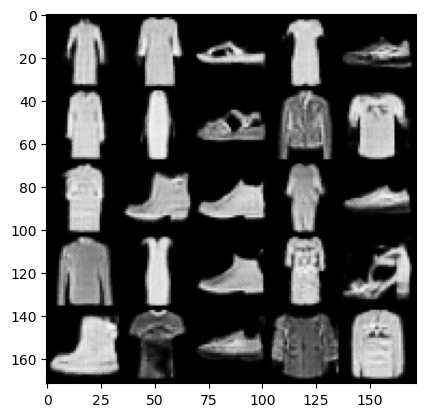

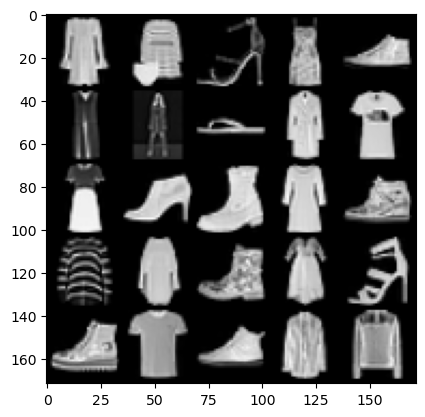

100%|██████████| 468/468 [02:00<00:00,  3.89it/s]

Epoch:18 loss_D: 849.57 loss_G: 12032.13


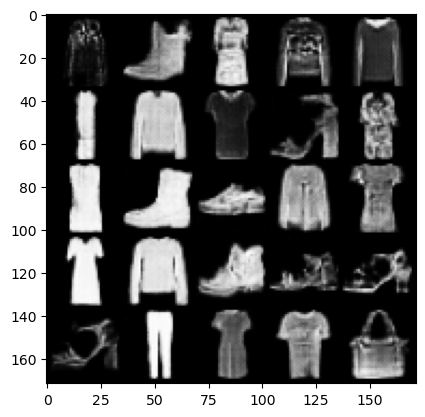

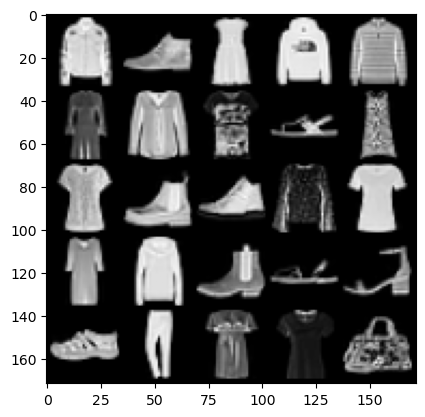

100%|██████████| 468/468 [02:00<00:00,  3.89it/s]

Epoch:19 loss_D: 815.47 loss_G: 11991.17


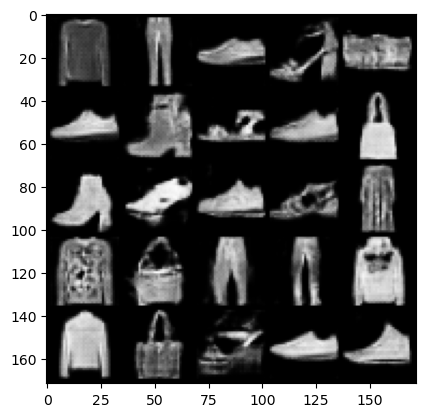

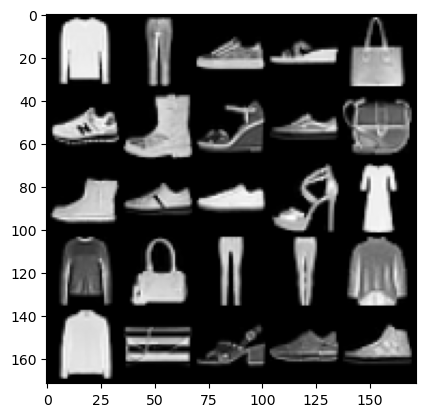

100%|██████████| 468/468 [01:57<00:00,  4.00it/s]

Epoch:20 loss_D: 726.39 loss_G: 12252.04


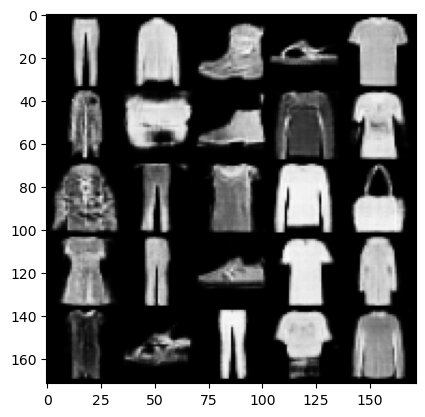

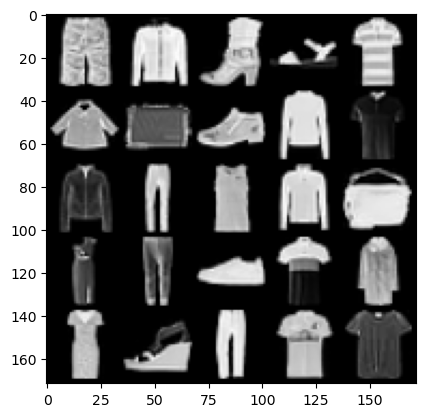

(array([3807.3916299 , 1837.78072029, 1464.07293493, 1285.79461816,
        1169.21866578, 1114.50839818, 1098.51942658, 1074.83453785,
        1051.36056548, 1006.08864051,  963.52623134,  955.81181952,
         921.37268742,  845.56392525,  848.43237965,  834.963343  ,
         797.75865838,  849.5691951 ,  815.47476599,  726.38501502]),
 array([-5.16400001e+03, -3.42893527e+03,  1.49193111e+00,  1.88311071e+03,
         3.10576125e+03,  4.33116625e+03,  6.17825059e+03,  8.34331000e+03,
         9.50214621e+03,  9.99982860e+03,  1.03500913e+04,  1.05894242e+04,
         1.08284667e+04,  1.08782514e+04,  1.09583461e+04,  1.12183425e+04,
         1.15157097e+04,  1.20321255e+04,  1.19911738e+04,  1.22520418e+04]))

In [47]:
in_channels = config.noise_size + config.num_classes
out_channels = 1
num_classes = 10
batch_size = config.batch_size
noise_size = config.noise_size

cwgan = CWGAN(
    in_channels=in_channels,
    out_channels=out_channels,
    num_classes=num_classes,
    batch_size=batch_size,
    noise_size=noise_size,
)

cwgan.fit(dataloader=dataloader, num_epochs=20, num_critic=config.num_critic)

Выводы:
- использование WGAN с weight clipping дает неплохое качество на датасете Fashion MNIST, однако требует долгой сходимости
- использование WGAN с gradient penalty дает сравнимо более быструю сходимость для получения хорошего качества
- проброс условия в модель осуществлялся через конктенацию лейблов, это достаточно простой метод, однако как мы можем видеть это дало неплохой качество на датасете Fashion MNIST